Reading:
    
GoodFellow. Deep Learning. p43-106

# Animation in jupyter notebook

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation, rc
from IPython.display import HTML

from scipy import stats 
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.datasets.samples_generator import make_regression 

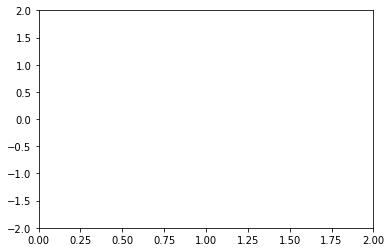

In [3]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [4]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [5]:
# animation function is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = 0.8*np.sin(2 * np.pi * (x - 0.01 * i)) + 0.2*np.sin(2 * np.pi * (x - 0.01 * i) * 10)
    line.set_data(x, y)
    return (line,)

In [6]:
# create animation object
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True # only re-draw the parts that have changed
                              )

In [7]:
HTML(anim.to_html5_video())

# Gradient Descent and SGD

## Example: Linear regression

$$f_\w (x) =w^T x$$

Loss:  
$$J(w) = \frac{1}{2} \sum_{i=1}^m (f_w (x_{i})-y_{i})^2$$


In [8]:
x, y = make_regression(n_samples = 1000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=42)

In [9]:
# train model - it will be our ground truth

from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(x,y)
model.coef_, model.intercept_

(array([16.51883388]), 0.09052411811641858)

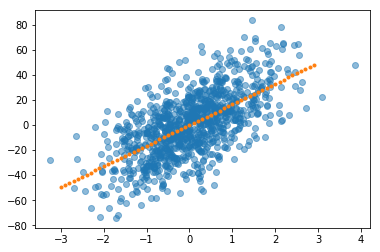

In [10]:
x = x.flatten()
best_fit = np.vectorize(lambda x: x * model.coef_[0] + model.intercept_)

plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

## Batch gradient descent

$$J(w) =\sum_{i=1}^m J_i(w)$$

where $J_i$ is associated with the i-th observation in our data set. Given some initial feasible  $w$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$w := w - \eta \nabla_{w} J(w) = w -\eta \sum_{i=1}^m \nabla J_i(w)$$

where $\eta$ is a constant controlling step-size and is called the learning rate.

Batch gradient descent is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.

In the given example the update step takes the form:

$$ w_j := w_j + \alpha \sum_{i=1}^m (y_{i} - f_w (x_{i})) x_{i,j}$$

In [11]:
# MSE loss function
def mse_loss(y_true, y_pred):
    return 0.5 * np.mean((y_true - y_pred)**2)

# MSE loss gradient
def mse_loss_grad(x, y_true, w):
    return x.T.dot(x.dot(w) - y_true) / len(y_true)

In [37]:
def gradient_descent(x, y, w_init, step=0.001, max_iters=10**5, tol=0.001, ):
    """
    x: feature matrix
    y: target variable
    w_init: initial guess for parameters
    step: learning rate
    max_iters: maximum itterations of gradient descent
    tol: precision for stopping creterion
    """
    w = w_init
    
    y_pred = x.dot(w)
    prev_loss = mse_loss(y, y_pred)
    loss_hist = [prev_loss]
    pred_hist = [x.dot(w)]
    w_hist = [w]
    
    for i in range(max_iters):
        # update
        w = w - step * mse_loss_grad(x, y, w)
        
        y_pred = x.dot(w)
        loss = mse_loss(y, y_pred)
        
        # logging
        loss_hist.append(loss)
        w_hist.append(w)
        if i % 25 ==0:
            pred_hist.append(y_pred)
        
        # stop criterion
        if  np.abs(loss - prev_loss) < tol:
            break
        prev_loss = loss
            
    return w_hist, loss_hist, pred_hist

In [40]:
# merge bias term into feature matrix
#  x -> (1, x)
xaug = np.hstack([np.ones((len(x),1)), x.reshape(-1,1)])

# initial guess
w_init = [-15, 40] + np.random.rand(2)
w_hist, loss_hist, pred_hist = gradient_descent(xaug, y, w_init, step=0.01)

# optimal weights
w_final = w_hist[-1]

In [41]:
print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(w_final[0], w_final[1], len(loss_hist)))
print("Least Squares: {:.2f}, {:.2f}".format(model.intercept_, model.coef_[0]))

Gradient Descent: -0.07, 16.81 466
Least Squares: 0.09, 16.52


One can plot the reduction of loss:

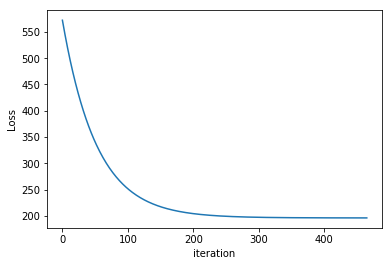

In [42]:
# loss per iteration
plt.plot(range(len(loss_hist)), loss_hist);
plt.ylabel('Loss')
plt.xlabel('iteration');

The following animation shows how the regression line forms:

In [43]:
from IPython.display import HTML

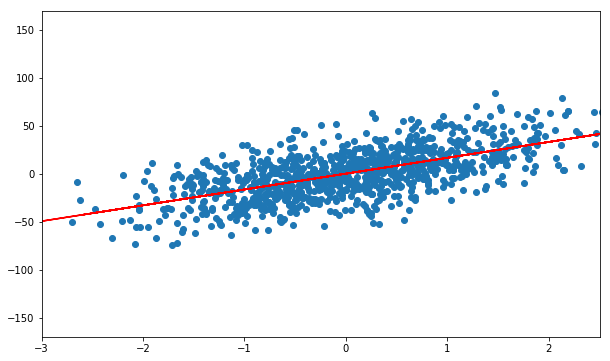

In [44]:
def init():
    line.set_data([], [])
    return line,

def animate(i):
    ys = pred_hist[i]
    line.set_data(xaug[:, 1], ys)
    return line,



fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(xaug[:,1],y, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(xaug[:,1], best_fit(xaug[:,1]), 'k-', color = "r")

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(pred_hist), interval=100)

HTML(anim.to_html5_video())

Remember that the linear regression cost function is convex, and more precisely quadratic. We can see the path that gradient descent takes in arriving at the optimum:

In [45]:
from mpl_toolkits.mplot3d import Axes3D


def make_3d_plot(x_final, y_final, z_final, w_hist, loss_hist, xaug, y):
    
    # make space around minimum
    ms = np.linspace(x_final - 20 , x_final + 20, 20)
    bs = np.linspace(y_final - 40 , y_final + 40, 40)
    M, B = np.meshgrid(ms, bs)
    zs = np.array([mse_loss(xaug.dot(w), y)  for w in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)
    ax.set_xlabel('Intercept')
    ax.set_ylabel('Slope')
    ax.set_zlabel('Loss')
    ax.view_init(elev=30., azim=-15)
    
    ax.plot([x_final], [y_final], [z_final] , 
            markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in w_hist], [t[1] for t in w_hist], loss_hist , 
            markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in w_hist], [t[1] for t in w_hist], 0 , 
            alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
    
def plot_optimization_path(xaug, y, w_final, loss_hist, w_hist):
    make_3d_plot(w_final[0], w_final[1], loss_hist[-1], w_hist, loss_hist, xaug, y)

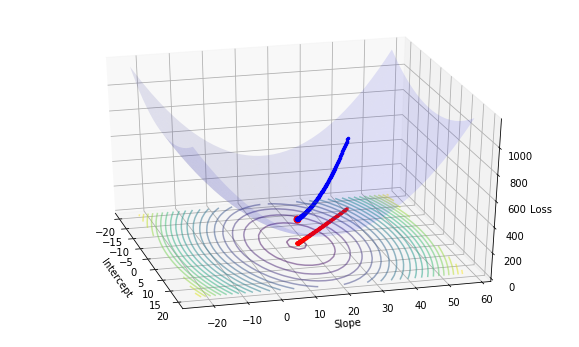

In [46]:
plot_optimization_path(xaug, y, w_final, loss_hist, w_hist)

## Stochastic gradient descent

When we have very large data sets, the calculation of $\nabla J(w)$ can be costly as we must process every data point before making a single step (hence the name "batch"). An alternative approach, the stochastic gradient descent method, is to update $w$ sequentially with every observation. The updates then take the form:

$$w := w - \alpha \nabla_{w} J_i(w)$$

This stochastic gradient approach allows us to start making progress on the minimization problem right away. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent. 

Generally, the stochastic gradient descent method will get close to the optimal $w$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we want a quick and dirty approximation for the solution to our optimization problem. 
    
The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order. 

For a given epoch, we first reshuffle the data, and then for a single example, we evaluate the gradient of the loss function and then update the params with the chosen learning rate.

The update for linear regression is:

$$w_j := w_j + \alpha (y_{i}-f_w (x_{i})) x_{j,i}$$


In [47]:
def sgd(x, y, w_init, step=0.001, n_epochs=10, tol=0.001, batch_size=4):
    """
    x : feature matrix
    y: target
    w_init: initial guess
    step: learning rate
    n_epochs: number of loops through whole dataset
    tol: precision for stopping creterion
    batch_size: 
    """
    
    w = w_init
   
    y_pred = x.dot(w)
    prev_loss = mse_loss(y, y_pred)
    loss_hist = [prev_loss]
    pred_hist = [x.dot(w)]
    w_hist = [w]
    
    n_batches = int(np.ceil(len(x) / batch_size))
    
    for epoch in range(n_epochs):
        loss_mean = 0
        for i in range(n_batches): 
            
            batch_indices = np.random.choice(len(x), len(x))
            x_batch = x[batch_indices[i: i + batch_size]]
            y_batch = y[batch_indices[i: i + batch_size]]
            
            # update
            w = w - step * mse_loss_grad(x_batch, y_batch, w)

            y_pred = x_batch.dot(w)
            loss = mse_loss(y_batch, y_pred)
            loss_mean += loss
            
        loss_mean = loss_mean / n_batches

        # logging
        loss_hist.append(loss_mean)
        w_hist.append(w)
        if i % 25 ==0:
            pred_hist.append(y_pred)

        # stop criterion
        if  np.abs(loss_mean - prev_loss) < tol:
            break
        prev_loss = loss_mean
            
    return w_hist, loss_hist, pred_hist

In [48]:
w_hist, loss_hist, pred_hist = sgd(xaug, y, w_init, n_epochs=100, step=0.01, batch_size=4)

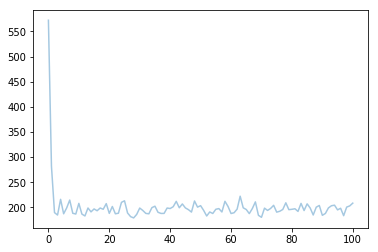

In [49]:
plt.plot(range(len(loss_hist[-10000:])), loss_hist[-10000:], alpha=0.4);

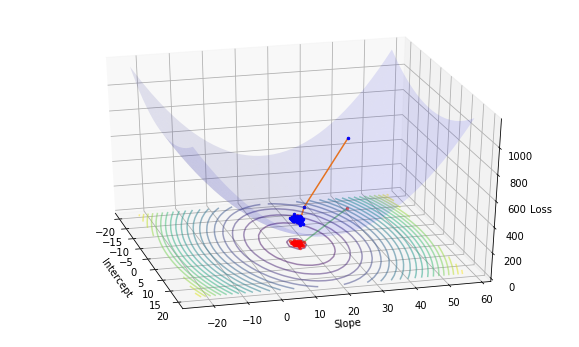

In [50]:
plot_optimization_path(xaug, y, w_final, loss_hist, w_hist)

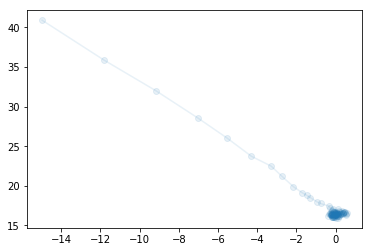

In [36]:
# projection on paremeter space
plt.plot([t[0] for t in w_hist], [t[1] for t in w_hist],'o-', alpha=0.1)